# Quantification of the Asymmetry

# Introduction

The main objective of this notebook is to fetch asymmetry parameters from given image of dermatology issue.

# Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from functions import *
from skimage.draw import line as skimage_line
import math
%matplotlib inline

# Loading image

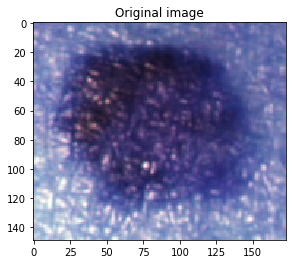

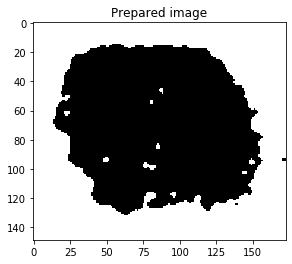

In [2]:
original_img = cv2.imread('39.jpg')

# function from functions.py, basicly shows given image
simg(original_img, "Original image", cmap='gray')

# image thresholding using peak slicing
img = prepare_image_peak_slicing(original_img, median_filter=True)

simg(img, "Prepared image")

    

# Contour detection

Finding pigmented area using "find contour" function from OpenCV. Contour with longest perimeter is taken as wanted nevi contour. Figures below shows how dilation affects on Canny filter and contour selection methods.

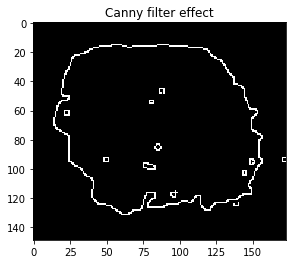

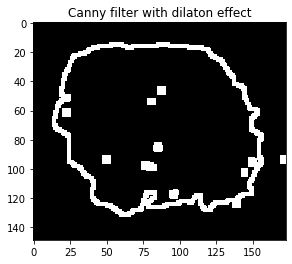

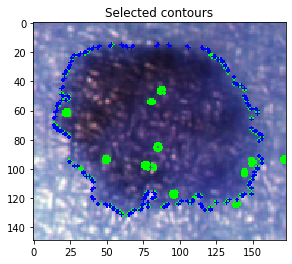

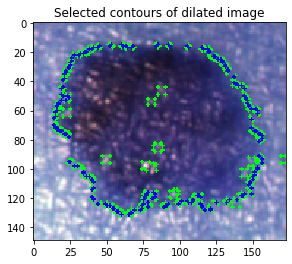

In [3]:
img_blur = cv2.GaussianBlur(img, (7, 7), sigmaX=1)

img_canny = cv2.Canny(img_blur,100,200)

img_dilation = cv2.dilate(img_canny, np.ones((3, 3), np.uint8), iterations=1)

simg(img_canny, "Canny filter effect")
simg(img_dilation, "Canny filter with dilaton effect")

contours, hierarchy = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_d, hierarchy_d = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_template = original_img.copy()
img_template_dilate = original_img.copy()

max_length = 0
max_length_cnt = None
for i, cnt in enumerate(contours):
    cv2.drawContours(img_template, cnt, -1, (0, 255, 0), 2)
    if cv2.arcLength(cnt,True) > max_length:
        max_length = cv2.arcLength(cnt, True)
        max_length_cnt = cnt
    
for cnt in contours_d:
    cv2.drawContours(img_template_dilate, cnt, -1, (0, 255, 0), 2)
    if cv2.arcLength(cnt,True) > max_length:
        max_length = cv2.arcLength(cnt, True)
        max_length_cnt = cnt

        
cv2.drawContours(img_template, max_length_cnt, -1, (0, 0, 255), 2)
cv2.drawContours(img_template_dilate, max_length_cnt, -1, (0, 0, 255), 2)  
simg(img_template, "Selected contours")
simg(img_template_dilate, "Selected contours of dilated image")

# Finding and drawing contour, convex hull and bounding box
Function <i>connect_points</i> connects given points and draw connected lines on given image. Convex hull and bounding box were found using OpenCV functions.

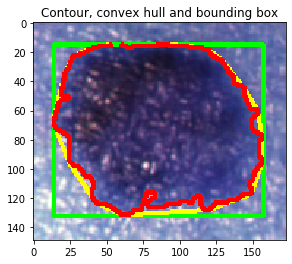

In [4]:
def connect_points(dest, cnt, color, thickness):
    for i in range(1, cnt.shape[0]):
        cv2.line(dest, (cnt[i][0][0], cnt[i][0][1]), (cnt[i-1][0][0], cnt[i-1][0][1]), color, thickness)
        

shapes_image = original_img.copy()
x, y, w, h = cv2.boundingRect(max_length_cnt)
cv2.rectangle(shapes_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
hull = cv2.convexHull(max_length_cnt)

connect_points(shapes_image, hull, (255, 255, 0), 2)
connect_points(shapes_image, max_length_cnt, (255, 0, 0), 2)

simg(shapes_image, "Contour, convex hull and bounding box", cmap='hsv')

# Finding axes
Function below finding longest axe of contour and returns its points.

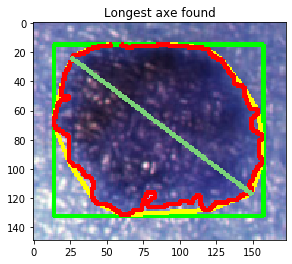

In [5]:
def find_longest_axe2(cnt):
    
    longest_axe = 0
    pt1_long = None
    pt2_long = None
    for pt1 in cnt:
        for pt2 in cnt:
            lenght = int(math.sqrt((pt2[0][0] - pt1[0][0])**2 + (pt2[0][1] - pt1[0][1])**2))
            if lenght > longest_axe:
                longest_axe = lenght
                pt1_long = pt1
                pt2_long = pt2
                    
    return (pt1_long[0][0], pt1_long[0][1]), (pt2_long[0][0], pt2_long[0][1]), longest_axe

pt1, pt2, length = find_longest_axe2(max_length_cnt)

longest_axe_image = original_img.copy()
cv2.line(shapes_image, pt1, pt2, (123, 211, 121), 2)
simg(shapes_image, "Longest axe found")

Function <i>repair_contour</i> adds points of spaces between points of given function to new contour list, in order to make selected contour more consistent. This is necessary procedure to provide successful normal axe search. Function <i>find_normal_axe</i> returns points of normal axe of fiven axe.

156


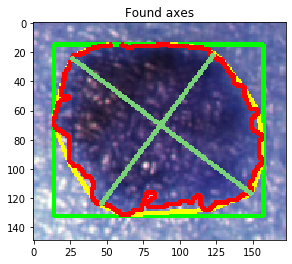

In [6]:
def repair_contour(cnt):
    new_contour = []
    mod = cnt.shape[0]
    for i in range(1, cnt.shape[0]+1):
        ind = i%mod
        line_x, line_y = skimage_line(cnt[ind][0][0], cnt[ind][0][1], cnt[ind-1][0][0], cnt[ind-1][0][1])
        for x, y in zip(line_x, line_y):
            new_contour.append([[x, y]])
    
    return np.array(new_contour)

def find_normal_axe(cnt, pt1, pt2):
    S = (int((pt1[0]+pt2[0])/2), int((pt1[1]+pt2[1])/2))
    a_1 = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
    a_2 = -1/a_1
    b = S[1] - a_2*S[0]
    y_max = max(cnt[:, :, 1])
    y_min = min(cnt[:, :, 1])
    
    x_max = max(cnt[:, :, 0])
    x_min = min(cnt[:, :, 0])
    
    print("S = {}, a_1 = {}, a_2 = {}, b = {}, y_max = {}, y_min = {}, x_max = {}, x_min = {}".format(S, a_1, a_2, b, y_max, y_min, x_max, x_min))
    
    line_y_minus = np.arange(S[1], y_min, a_2, dtype="int16")
    line_y_plus = np.arange(S[1]+1, y_max, -a_2, dtype="int16")
    
    line_x_minus = np.arange(S[0], x_max, 1, dtype="int16")
    line_x_plus = np.arange(S[0]+1, x_min, -1, dtype="int16")
    
    
    print("line_y_plus = {}".format(line_y_plus))
    print("line_y_minus = {}".format(line_y_minus))
    
    print("line_x_plus = {}".format(line_x_plus))
    print("line_x_minus = {}".format(line_x_minus))
    
    print("zipped line_y_plus = {}".format(list(zip(line_x_plus, line_y_plus))))
    print("zipped line_y_minus = {}".format(list(zip(line_x_minus, line_y_minus))))
    
def find_normal_axe2(cnt, pt1, pt2, tolerance=2):
    # Calculate S - point in the middle between pt1 and pt2
    S = (int((pt1[0]+pt2[0])/2), int((pt1[1]+pt2[1])/2))
    
    # Calculate a_1
    a_1 = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
    
    # Calculate a_2
    a_2 = -1/a_1
    
    # Calculate b
    b = S[1] - a_2*S[0]
    
    # Calculate max_x
    max_x = max(cnt[:,:,0])[0]
    print(max_x)
    
    pt1_res = None
    pt2_res = None
    
    for x in range(S[0], max_x):
        y = int(a_2*x + b)
        for x_cnt, y_cnt in cnt[:,0,:]:
            if x_cnt-tolerance < x < x_cnt+tolerance and y_cnt-tolerance < y < y_cnt+tolerance:
                pt1_res = (x, y)
                break
            
    for x in range(0, S[0]-1):
        y = int(a_2*x + b)
        for x_cnt, y_cnt in cnt[:,0,:]:
            if x_cnt-tolerance < x < x_cnt+1 and y_cnt-tolerance < y < y_cnt+tolerance:
                pt2_res = (x, y)
                break
    
    return pt1_res, pt2_res
    
    

pt1_res, pt2_res = find_normal_axe2(repair_contour(max_length_cnt), pt1, pt2)

cv2.line(shapes_image, pt1_res, pt2_res, (123, 211, 121), 2)
simg(shapes_image, "Found axes")

Image below shows how repaired contour looks like on original image.

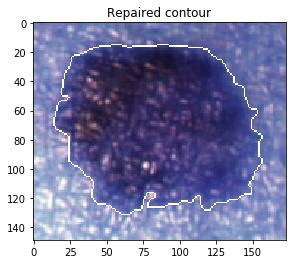

In [7]:
rep = repair_contour(max_length_cnt)

repaired_img_cnt = original_img.copy()

for x, y in rep[:,0,:]:
    repaired_img_cnt[y][x] = (255, 255, 255)
        
simg(repaired_img_cnt, "Repaired contour")

# Calculation of parameters

In [8]:
repaired_contour_area = cv2.contourArea(rep)
print("Area of repaired contour = {}".format(repaired_contour_area))

Area of repaired contour = 12834.5


In [9]:
repaired_hull = repair_contour(hull)
repaired_hull_area = cv2.contourArea(repaired_hull)
print("Area of repaired contour = {}".format(repaired_hull_area))

Area of repaired contour = 13028.0


In [10]:
bounding_box_area = w*h
print("Area of bounding box = {}".format(bounding_box_area))

Area of bounding box = 16731


In [11]:
a_p = length
b_p = int(math.sqrt((pt2_res[0] - pt1_res[0])**2 + (pt2_res[1] - pt1_res[1])**2))
print("Axes of pigmented area, a_p = {}, b_p = {}".format(a_p, b_p))

Axes of pigmented area, a_p = 154, b_p = 127


In [12]:
a_b = h
b_b = w
print("Axes of bounding box, a_b = {}, b_b = {}".format(a_b, b_b))

Axes of bounding box, a_b = 117, b_b = 143


In [13]:
p_p = cv2.arcLength(rep, False)
print("Perimeter of pigmented area = {}".format(p_p))

Perimeter of pigmented area = 1465.6604309082031


In [14]:
def entropy(prepared_image):
    sum_of_black = 0
    sum_of_white = 0
    
    for row in prepared_image:
        for pixel in row:
            if pixel == 0:
                sum_of_black += 1
            elif pixel == 255:
                sum_of_white += 1
    p_white = sum_of_white/(sum_of_black+sum_of_white)
    p_black = sum_of_black/(sum_of_black+sum_of_white)
    entropy = -(p_white*np.log2(p_white) + p_black*np.log2(p_black))
    return entropy
    

In [15]:
entropy_of_img = entropy(img)
print("Entropy of image = {}".format(entropy_of_img))

Entropy of image = 0.999863179795345
